In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [30]:
path = "/content/California_House_Prices_Data.csv"
df = pd.read_csv(path)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


In [31]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1I3a29lAo2S6LJSfKlwt5EZxlnJ3zFlME_bKvTMlKtOg/edit#gid=0


In [32]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB
None


In [33]:
# Quick statistics
desc_stats = df.describe()
desc_stats

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [34]:
# Fill missing bedrooms
from sklearn.impute import SimpleImputer

puter = SimpleImputer(strategy="median")
df["total_bedrooms"] = puter.fit_transform(df[["total_bedrooms"]])

In [35]:
#After filled missing values
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


In [36]:
#Check duplicates
df.duplicated().sum()

np.int64(0)

In [37]:
# Feature Engineering
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

# Handle infinity or NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600,6.984127,0.146591,2.555556
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500,6.238137,0.155797,2.109842
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100,8.288136,0.129516,2.802260
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300,5.817352,0.184458,2.547945
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200,6.281853,0.172096,2.181467


In [38]:
# --- Distribution of Target Variable ---
fig = px.histogram(
    df,
    x="median_house_value",
    nbins=50,
    marginal="box",  # adds a small boxplot above
    opacity=0.7,
    title="Distribution of Median House Value"
)
fig.update_layout(xaxis_title="House Value", yaxis_title="Frequency")
fig.show()

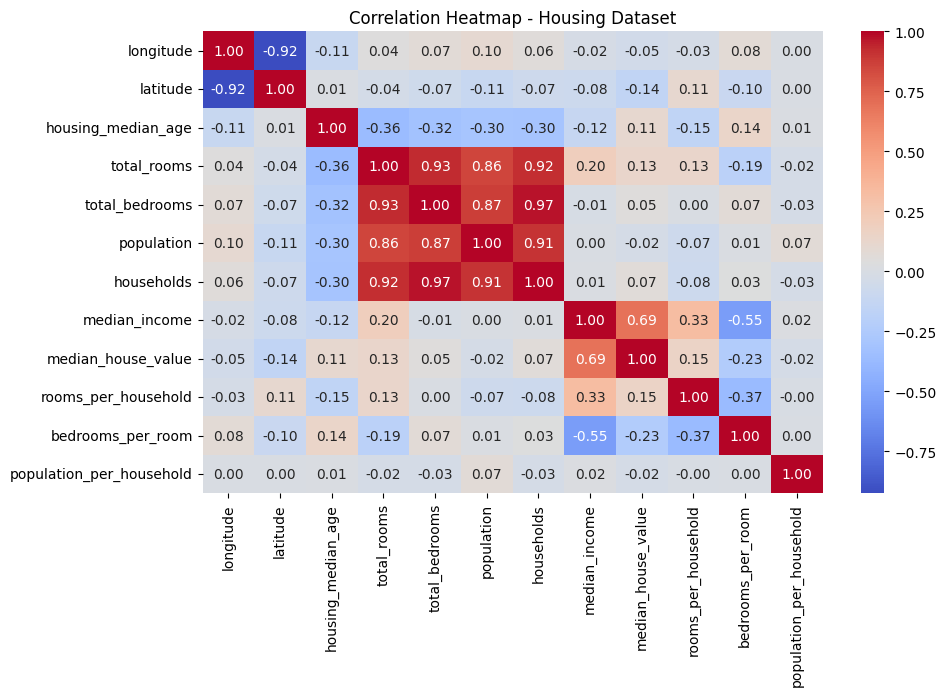

In [39]:
# Correlation heatmap (numeric features only)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap - Housing Dataset")
plt.show()

In [40]:
# Value counts for ocean_proximity
cat_counts = df["ocean_proximity"].value_counts().reset_index()
cat_counts.columns = ["ocean_proximity", "count"]

# Plotly bar chart
fig = px.bar(cat_counts,
             x="ocean_proximity",
             y="count",
             title="Ocean Proximity Distribution",
             text="count",   # show counts on bars
             color="ocean_proximity")

fig.update_layout(showlegend=False)  # hide duplicate legend
fig.show()


In [41]:
# Geo-visualization: Houses on California map
fig = px.scatter_mapbox(
    df,
    lat="latitude",
    lon="longitude",
    size="population",
    color="median_house_value",
    hover_name="ocean_proximity",
    hover_data=["housing_median_age", "total_rooms", "households"],
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=15,
    zoom=5,
    height=600,
    title="Housing Prices in California"
)


# Using open-street-map style
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [42]:
# Income vs House Value
fig = px.scatter(df, x="median_income", y="median_house_value", opacity=0.4,
                 title="Income vs House Value")
fig.show()

In [43]:
# Encode categorical
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)

In [44]:
num_cols = ["total_rooms", "total_bedrooms", "population", "median_income", "median_house_value"]

for col in num_cols:
    fig = px.box(
        df,
        y=col,
        title=f"Boxplot of {col}",
        points="all",  # sari data points including outliers
        template="plotly_white"
    )

    fig.update_traces(
        jitter=0.3,  # thoda spread kar deta hai points
        marker=dict(size=4, opacity=0.6, color="red")  # outliers red dots
    )

    fig.update_layout(
        yaxis_title=col,
        boxmode="overlay",
        width=600,
        height=400
    )

    fig.show()


array([[<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>],
       [<Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

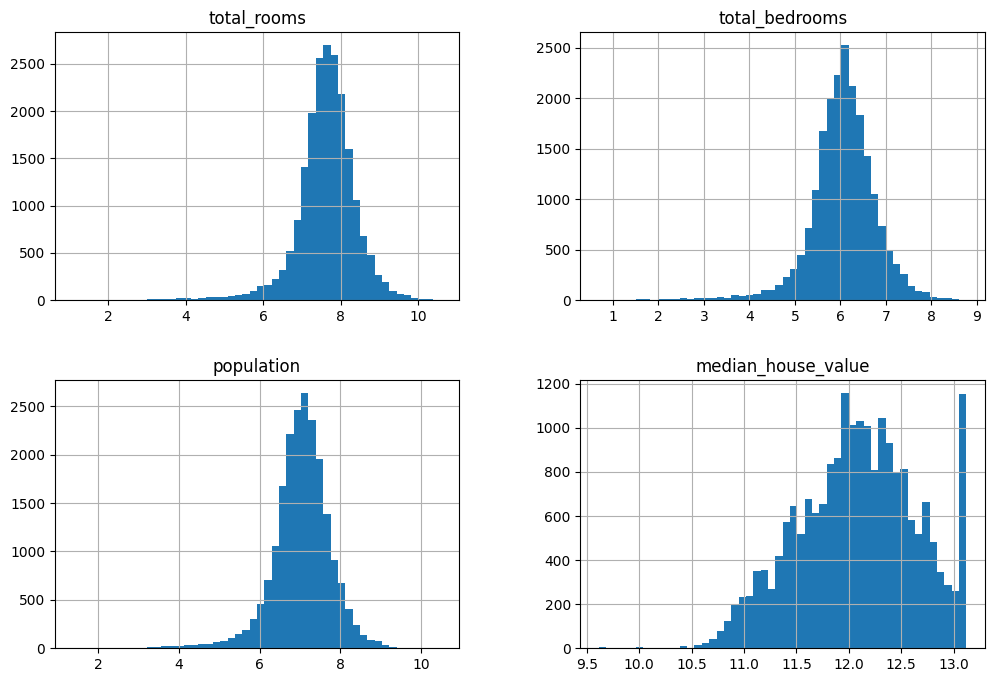

In [45]:
# Copy dataset
df_out = df.copy()

# Apply log transformation on skewed features
for col in ["total_rooms", "total_bedrooms", "population", "median_house_value"]:
    df_out[col] = np.log1p(df_out[col])   # log(1+x) to avoid log(0) issue

# Check again after transformation
df_out[["total_rooms", "total_bedrooms", "population", "median_house_value"]].hist(bins=50, figsize=(12,8))


In [46]:
# Function for capping (IQR method)
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return np.clip(series, lower, upper)

# Apply capping on selected columns
df_cap = df.copy()
for col in ["total_rooms", "total_bedrooms", "population", "median_house_value"]:
    df_cap[col] = cap_outliers(df_cap[col])

In [47]:
# Use capped dataset (or try df_out for log-transformed)
df_model = df_cap.copy()

In [48]:
# Features & Target
X = df_model.drop("median_house_value", axis=1)
y = df_model["median_house_value"]

In [49]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [51]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

In [52]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

In [53]:
print("XGBoost       → RMSE:", xgb_rmse, "R²:", xgb_r2)

XGBoost       → RMSE: 44711.084154338365 R²: 0.8418894033709651


In [54]:
# XGBoost GridSearch
xgb_params = {
    "n_estimators": [200, 500],
    "learning_rate": [0.05, 0.1],
    "max_depth": [4, 6]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, n_jobs=-1), xgb_params,
                        cv=3, scoring="r2", n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_scaled, y_train)

print("Best XGB Params:", xgb_grid.best_params_)
xgb_best = xgb_grid.best_estimator_
xgb_best_pred = xgb_best.predict(X_test_scaled)
print("Tuned XGB R²:", r2_score(y_test, xgb_best_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGB Params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}
Tuned XGB R²: 0.8418894033709651


In [55]:
import joblib
joblib.dump(xgb_best, "house_price_model.pkl")

['house_price_model.pkl']